# 批踢踢網路爬蟲







## 爬取看板資料

#### 使用requests抓取html資料，再利用BeautifulSoup解析，並得到UserID及留言內容(content)。

In [ ]:
for ele in soup.select('.title a'):
	innerRes = requests.get('https://www.ptt.cc' + ele['href'], cookies={'over18':'1'})
	innerSoup = BeautifulSoup(innerRes.text,'html.parser')
	print(innerRes.url)
	for push in innerSoup.select('.push'):
		if push.text == '檔案過大！部分文章無法顯示':
			continue
		userID = push.select('.push-userid')[0].text.strip()
		content = push.select('.push-content')[0].text.replace(':','',1).strip()

abcd1234  
今天天氣真好  
pony666  
我覺得可以  
qaz02589  
我覺得不行  
xxcqc250  
我愛大咪咪  
yang7777  
87  
  
...  

#### 將爬取的UserID及content寫入data(dictionary)。

In [ ]:
if userID not in data:
	data[userID] = []
	data[userID].append(content)
else:
	data[userID].append(content)

```
{  
    "abcd1234":["今天天氣真好"],  
    "pony666":["我覺得可以","6666666666"],  
    "qaz02589":["我覺得不行","糖糖先記著","先發給他"],  
    "xxcqc250":["我愛大咪咪","雞腿好吃","推"],  
    "yang7777":["87","87878787","8787","87878787878787"],  
    ...  
}  
```


## 加入MySQL資料庫

#### 使用pymysql將資料加入MySQL資料庫中，方便後續查詢。
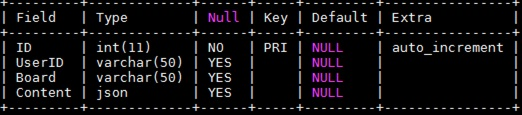

In [ ]:
boardArray = ['gossiping','baseball','lol','c_chat','stock','tech_job','sex','nba','movie','womentalk','mobilecomm','babymother','japan_travel','e-shopping','car','koreastar','beauty','joke','lifeismoney','marvel','boy-girl','pc_shopping']
db = pymysql.connect(host='140.120.13.242',port=33060,user='root',passwd='udiclab@720',database='yang_ptt',charset='utf8')
num = 0
for bn in boardArray:
	with open(bn + '.json','r') as file:
		data = json.load(file)
		for key,value in data.items():
			cursor = db.cursor()
			cursor.execute('insert into PTT(userID,board,content) values(%s,%s,%s)',(key,bn,json.dumps(value)))

## 查詢功能

#### 將資料從MySQL資料庫提出，並提供查詢某用戶在ptt上的留言狀況及在特定看板的留言內容。

In [ ]:
cursor = db.cursor()
cursor.execute('SELECT Board,Content FROM ptt_push as sql1 inner join (SELECT ID FROM ptt_push WHERE userID=%s) as sql2 on sql1.ID = sql2.ID',(UserID))
result = cursor.fetchall()
resultArray = []
if len(result) > 0:
	for ele in result:
		resultArray.append({'Board':ele[0],'Content':ele[1],'Times':len(json.loads(ele[1]))})
	sortedArray = sorted(resultArray, key=operator.itemgetter('Times'), reverse=True)

## 查詢demo

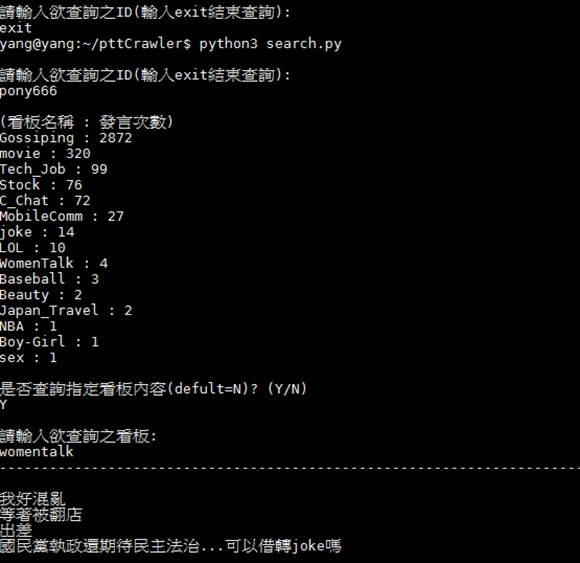